In [2]:
import scipy.io

# Load data
data = scipy.io.loadmat('data.mat')

# Print all keys in the .mat file
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'dt', 'dx', 'rawsection', 'wavelet'])


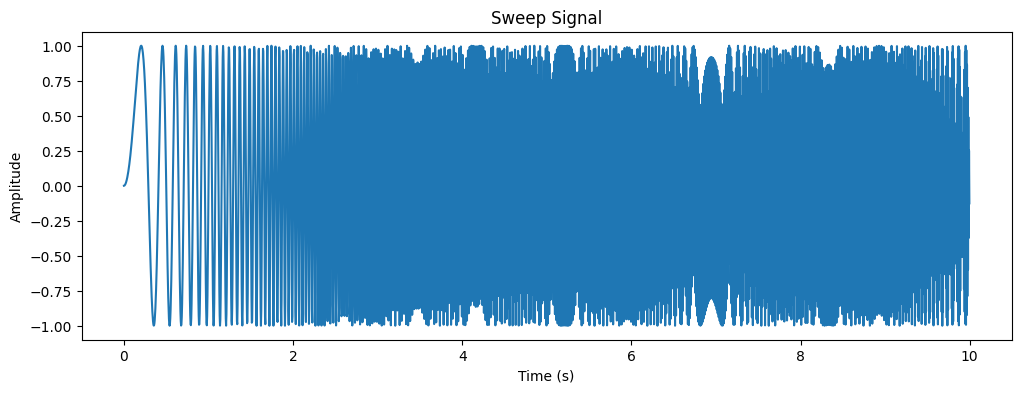

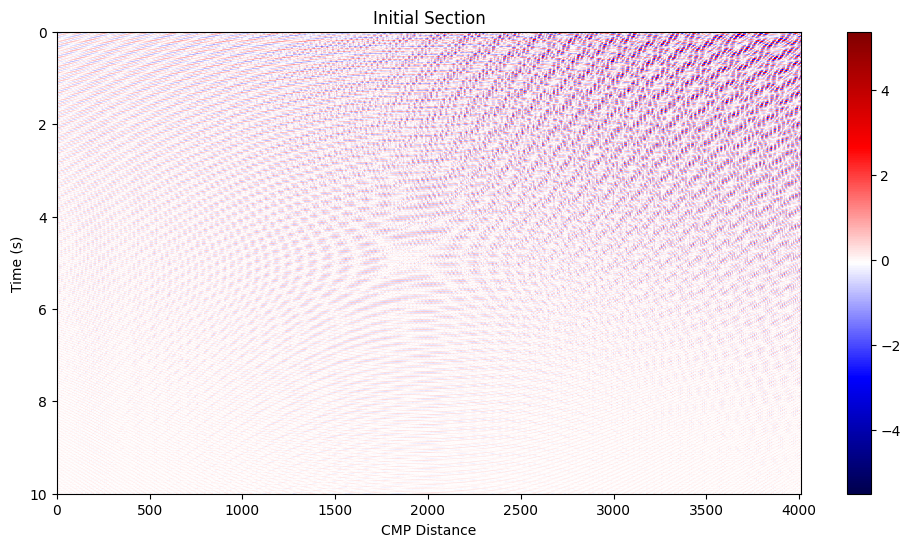

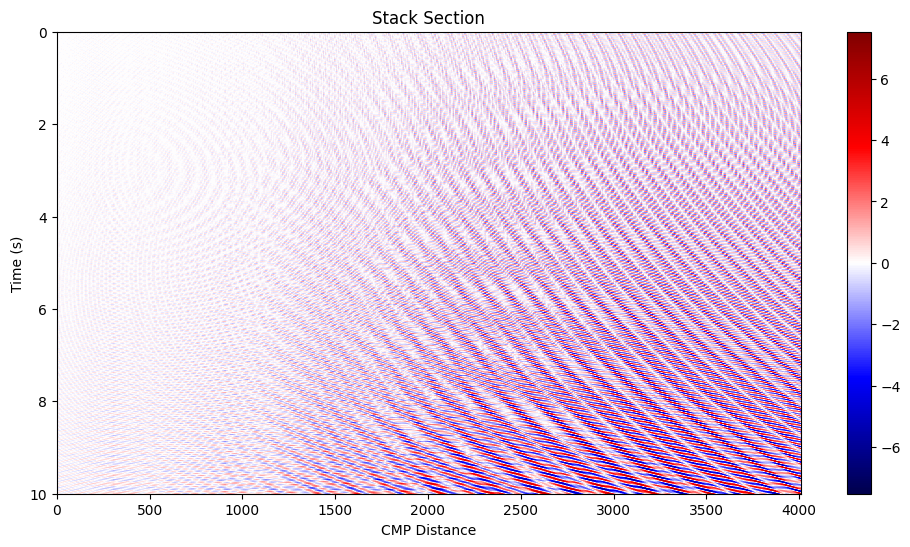

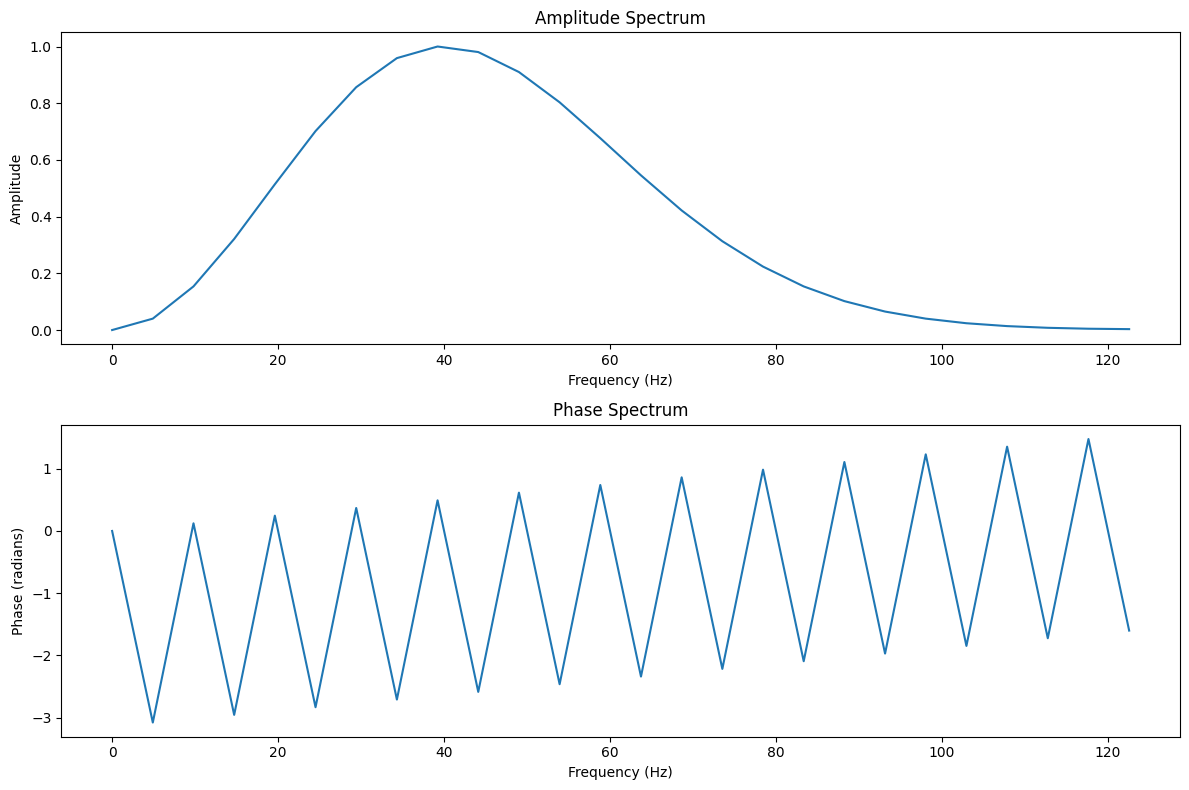

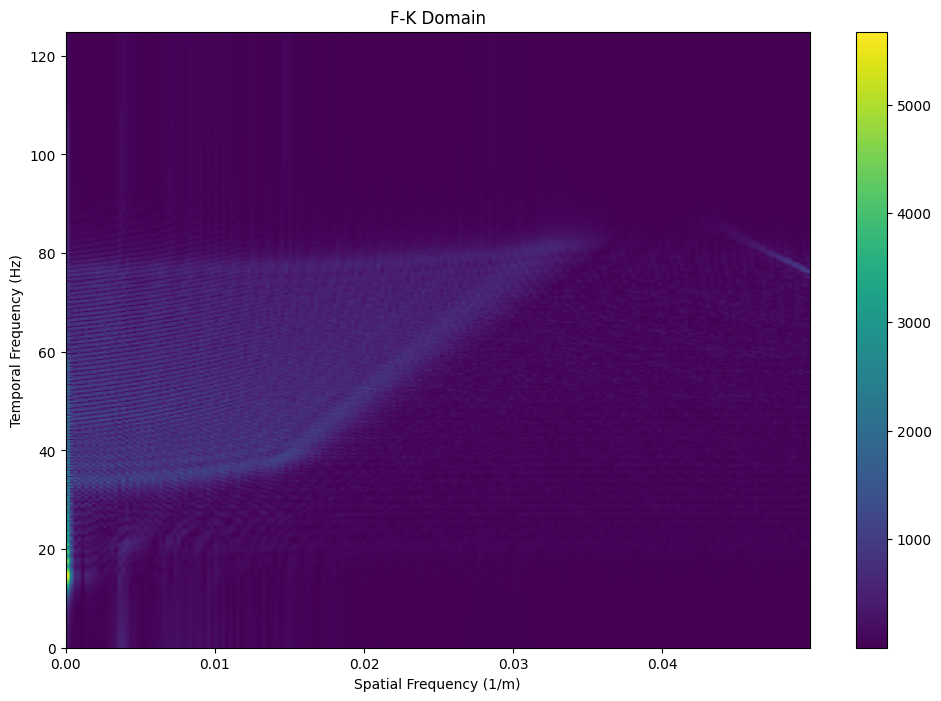

In [3]:
import numpy as np
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt

# Load the data
data = scipy.io.loadmat('data.mat')
dt = data['dt'][0][0]
dx = data['dx'][0][0]
rawsection = data['rawsection']
wavelet = data['wavelet']

# a) Generate and plot the sweep
t = np.arange(0, 10, dt)
f_max = 60  # Maximum frequency in Hz
sweep = np.sin(2 * np.pi * f_max * t**2 / 10)

plt.figure(figsize=(12, 4))
plt.plot(t, sweep)
plt.title('Sweep Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# b) Convolve sweep with section
initial_section = scipy.signal.convolve2d(rawsection, sweep[:, np.newaxis], mode='same')

plt.figure(figsize=(12, 6))
plt.imshow(initial_section, aspect='auto', cmap='seismic', extent=[0, initial_section.shape[1]*dx, 10, 0])
plt.title('Initial Section')
plt.xlabel('CMP Distance')
plt.ylabel('Time (s)')
plt.colorbar()
plt.show()

# c) Correlate and crop
stack_section = scipy.signal.correlate2d(rawsection, sweep[:, np.newaxis], mode='same')

plt.figure(figsize=(12, 6))
plt.imshow(stack_section, aspect='auto', cmap='seismic', extent=[0, stack_section.shape[1]*dx, 10, 0])
plt.title('Stack Section')
plt.xlabel('CMP Distance')
plt.ylabel('Time (s)')
plt.colorbar()
plt.show()

# d) Fourier transform of wavelet
wavelet_fft = np.fft.fft(wavelet.flatten())
freqs = np.fft.fftfreq(len(wavelet), dt)
positive_freq_mask = freqs >= 0

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(freqs[positive_freq_mask], np.abs(wavelet_fft)[positive_freq_mask])
plt.title('Amplitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(freqs[positive_freq_mask], np.angle(wavelet_fft)[positive_freq_mask])
plt.title('Phase Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.tight_layout()
plt.show()

# e) 2D Fourier transform of stack section
stack_fft = np.fft.fft2(stack_section)
kx = np.fft.fftfreq(stack_section.shape[1], dx)
ky = np.fft.fftfreq(stack_section.shape[0], dt)

# Create masks for positive frequencies
kx_positive = kx >= 0
ky_positive = ky >= 0

plt.figure(figsize=(12, 8))
plt.imshow(np.abs(stack_fft[np.ix_(ky_positive, kx_positive)]), aspect='auto', 
           extent=[0, kx[kx_positive].max(), 0, ky[ky_positive].max()],
           origin='lower')
plt.title('F-K Domain')
plt.xlabel('Spatial Frequency (1/m)')
plt.ylabel('Temporal Frequency (Hz)')
plt.colorbar()
plt.show()

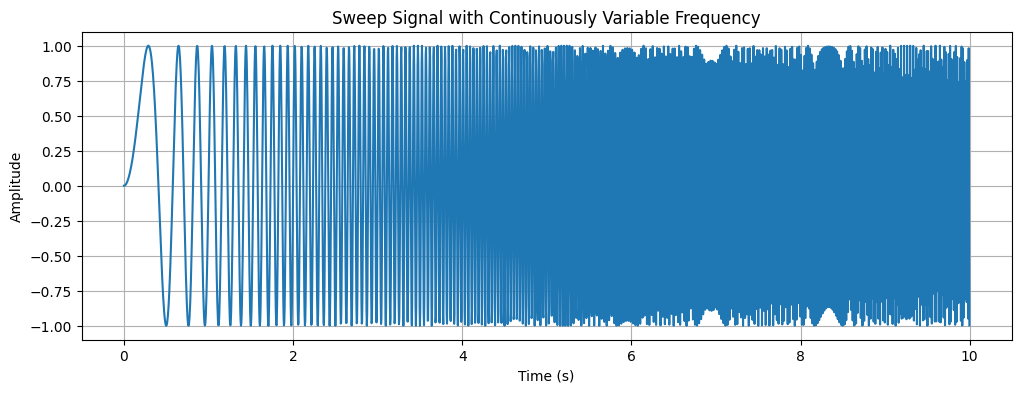

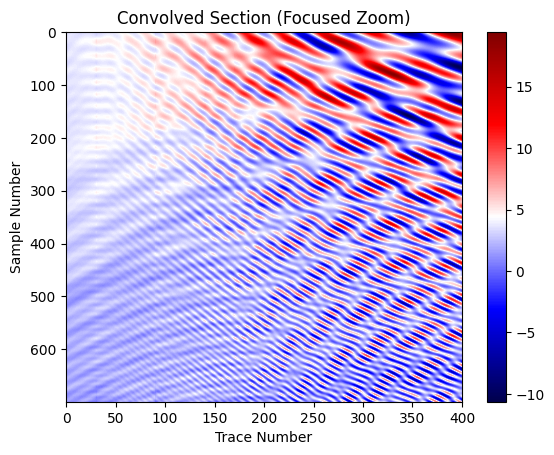

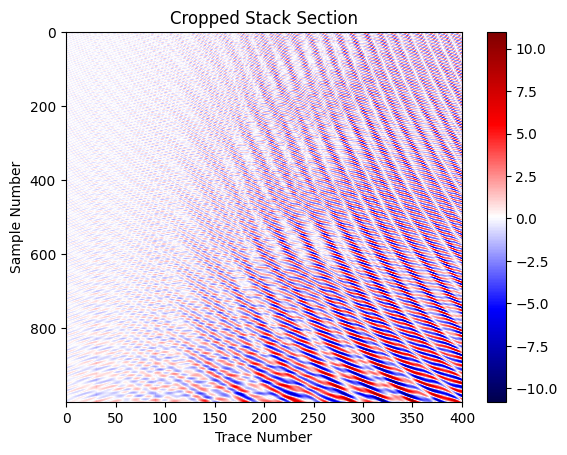

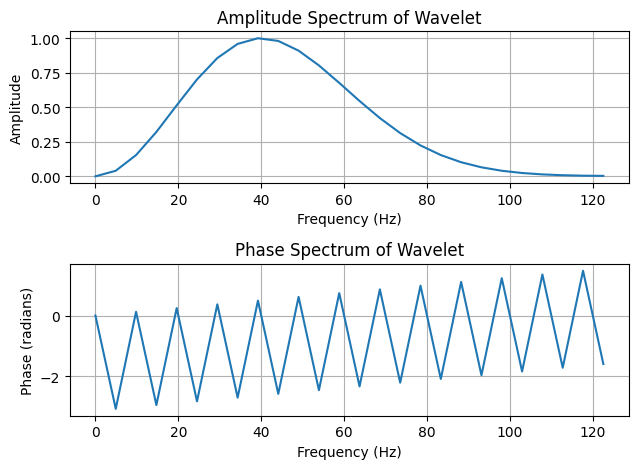

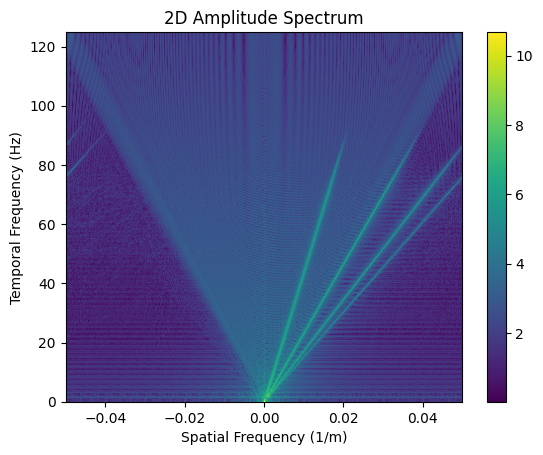

In [12]:
import numpy as np
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt

# Load the data
data = scipy.io.loadmat('data.mat')
dt = data['dt'][0][0]
dx = data['dx'][0][0]
rawsection = data['rawsection']
wavelet = data['wavelet']

# Part (a): Generate the sweep signal
sweep_length = 10  # Sweep length in seconds
max_frequency = 60  # Maximum frequency in Hz
t = np.arange(0, sweep_length, dt)  # Time vector
sweep_signal = np.sin(2 * np.pi * (max_frequency / sweep_length) * (t ** 2) / 2)

# Plot the sweep signal
plt.figure(figsize=(12, 4))
plt.plot(t, sweep_signal)
plt.title('Sweep Signal with Continuously Variable Frequency')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Part (b): Convolve sweep signal with the reflectivity section
n_samples, n_traces = rawsection.shape
convolved_section = np.zeros((n_samples + len(sweep_signal) - 1, n_traces))

for i in range(n_traces):
    convolved_section[:, i] = np.convolve(rawsection[:, i], sweep_signal, mode='full')

# Adjust dimensions for visualization (focused zoom range)
zoom_start = round(convolved_section.shape[0] * 0.1)  # Start at 10% of the data
zoom_end = round(convolved_section.shape[0] * 0.3)    # End at 30% of the data

# Plot the convolved section (focused zoom for clarity)
plt.figure()
plt.imshow(convolved_section[zoom_start:zoom_end, :], aspect='auto', cmap='seismic')
plt.title('Convolved Section (Focused Zoom)')
plt.xlabel('Trace Number')
plt.ylabel('Sample Number')
plt.colorbar()
plt.show()

# Part (c): Correlate each trace with the sweep signal to make the stack section
correlated_section = []

for i in range(n_traces):
    single_corr = np.correlate(rawsection[:, i], sweep_signal, mode='full')
    if len(correlated_section) == 0:
        correlated_section = np.zeros((len(single_corr), n_traces))
    correlated_section[:, i] = single_corr

correlated_section = np.array(correlated_section)

# Crop the correlated section to focus on the central interval
mid_point = correlated_section.shape[0] // 2  # Midpoint of the cross-correlation
crop_range = slice(mid_point - n_samples // 2, mid_point + n_samples // 2)  # Focus on the main event
cropped_section = correlated_section[crop_range, :]  # Crop results

# Plot the cropped stack section
plt.figure()
plt.imshow(cropped_section, aspect='auto', cmap='seismic')
plt.title('Cropped Stack Section')
plt.xlabel('Trace Number')
plt.ylabel('Sample Number')
plt.colorbar()
plt.show()

# Compute the Fourier transform of the wavelet
wavelet_fft = np.fft.fft(wavelet.flatten())
n = len(wavelet)

# Frequency vector
f = np.fft.fftfreq(n, dt)
positive_freqs = f >= 0

# Compute the amplitude and phase spectra
amplitude_spectrum = np.abs(wavelet_fft)
phase_spectrum = np.angle(wavelet_fft)

# Plot the amplitude spectrum
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(f[positive_freqs], amplitude_spectrum[positive_freqs])
plt.title('Amplitude Spectrum of Wavelet')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)

# Plot the phase spectrum
plt.subplot(2, 1, 2)
plt.plot(f[positive_freqs], phase_spectrum[positive_freqs])
plt.title('Phase Spectrum of Wavelet')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute the 2D Fourier Transform
fft2_rawsection = np.fft.fft2(rawsection)
fft2_shifted = np.fft.fftshift(fft2_rawsection)

# Compute the amplitude and phase spectra
amplitude_spectrum_2d = np.abs(fft2_shifted)
phase_spectrum_2d = np.angle(fft2_shifted)

# Frequency axes for plotting
freq_time = np.fft.fftfreq(n_samples, dt)
freq_space = np.fft.fftfreq(n_traces, dx)

# Adjust spatial frequency range
spatial_freq_range = (-0.05, 0.05)
freq_space_mask = (freq_space >= spatial_freq_range[0]) & (freq_space <= spatial_freq_range[1])
freq_time_positive = freq_time[freq_time >= 0]

# Plot the 2D amplitude spectrum
plt.figure()
plt.imshow(np.log(1 + amplitude_spectrum_2d[np.ix_(freq_time >= 0, freq_space_mask)]), aspect='auto',
           extent=[spatial_freq_range[0], spatial_freq_range[1], freq_time_positive.min(), freq_time_positive.max()])
plt.title('2D Amplitude Spectrum')
plt.xlabel('Spatial Frequency (1/m)')
plt.ylabel('Temporal Frequency (Hz)')
plt.colorbar()
plt.show()
